<div  style="border-bottom: 2px solid #5c5c5c33;" dir="rtl" >
    <div  style="font-size: 30px;margin-bottom: 20px; text-align: center;">بسم الله الرحمن الرحیم</div>
    <br>
    <div style="font-size:20px; padding-bottom: 20px;line-height: 2; text-align: center;"> طراحی سامانه های یادگیری ماشین <br> تمرین اول</div>
    <div style="font-size:17px; direction:rtl;padding-bottom: 15px;">نام و نام خانوادگی : زینب احیائی</div>
    <div style="font-size:17px; direction:rtl; padding-bottom: 15px;">شماره دانشجویی : 400201061</div>
</div>

In [198]:
import json
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# !pip install hazm 
from __future__ import unicode_literals
from hazm import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# !pip install tensorflow transformers bert-for-tf2
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.datasets import make_classification
import torch.nn.functional as F

<div dir="rtl">
    <h2 style="padding-bottom: 20px;">آماده‌سازی داده</h2>
    <div style="font-size: 16px;line-height: 1.6;">
        در این بخش ابتدا داده‌های خام مربوط به ۱۲۲۱ محصول از طریق خزش در وب سایت <a href="https://divar.ir/">دیوار</a>
     در دسته کالاهای دیجیتال و در زیر دسته‌های موبایل و تبلت، رایانه، کنسول و بازی ویدئویی و آنلاین  
        و صوتی و تصویری  و از بین آگهی‌های شهر‌های تهران، مشهد، شیراز و اصفهان جمع آوری شده است.
        این کار با استفاده از <a href="https://scrapy.org/">scrapy</a>
        و در دو مرحله انجام شده است.
        در مرحله اول آدرس‌های این محصولات به دست آمده و در مرحله بعد اطلاعات محصول از داخل این صفحات استخراج شده است.
        برای استخراج آدرس‌ها از spider ای با ساختار زیر استفاده شده است:
    </div>
</div>

```
import scrapy
from scrapy.selector import Selector
from selenium import webdriver
import time

class URLSpider(scrapy.Spider):
    name = "urlspider"
    allowed_domains = ["divar.ir"]
    start_urls = ["https://divar.ir/s/mashhad/mobile-tablet"]
    
    def __init__(self):
        self.driver = webdriver.Chrome()
        self.count = 0


    def closed(self, reason):
        self.driver.quit()


    def parse(self, response):
        self.driver.get(response.url)

        # Scroll down and load more data
        while True:
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            sel = Selector(text=self.driver.execute_script("return document.body.innerHTML;"))

            for post in sel.css('div.post-card-item-af972'):
                self.count = self.count + 1
                href = post.css('a:nth-child(1)::attr(href)').extract()

                yield {
                    'href': href,
                }
            
            if self.count > 200 :
                break

        self.driver.quit()
```

<div dir="rtl" style="font-size: 16px;line-height: 1.6">
      برای استخراج اطلاعات محصول نیز از spider ای با ساختار زیر استفاده شده است:
</div>


```
import json
import time
from scrapy import Spider, Request, Selector

class DataSpider(Spider):
    name = 'dataspider'
   
    def start_requests(self):
        with open('/Users/zeinab/Desktop/MLSD_HW1/scrapy/divar/urls/mashhad-mobile-tablet.json', 'r') as f:
            urls = json.load(f)
        for url in urls:
            time.sleep(1)
            yield Request(url="https://divar.ir" + url["href"][0], callback=self.parse)

    def parse(self, response):
        price = ''
        for value in response.css('p.kt-unexpandable-row__value'):
            if('تومان' in value.css("::text").get().strip()):
                price = value.css("::text").get().strip()

        img_div = response.css('div.kt-carousel__thumbnails')
        img_count = len(img_div.css('img'))

        yield {
            'title' : response.css('div.kt-page-title__title::text').get(),
            'desc' : response.css('p.kt-description-row__text::text').get(),
            'brand' : response.css('a.kt-unexpandable-row__action::text').get(),
            'image-count' : max(1, img_count),
            'price' : price,
            'city' : 'Mashhad',
            'category' : 'mobile-tablet'
        }
```

<div  dir="rtl" style="font-size: 16px;line-height: 1.6;">
      در نهایت نتایج در یک فایل json با فرمتی مشابه زیر ذخیره شده است:
</div>


```
[
    {
    "title": "سینما خانگی سامسونگ ۱۰۰۰ وات، ساخت اندونزی",
    "desc": "سینما خانگی ۷ تیکه دارای ۴ باند یک ساب، یک DVD player ، یک باند کوچک رو میزی، حدود ۲ ساله استفاده نشده، بسیار تمیز",
    "brand": null,
    "image-count": 4,
    "price": "۳٬۷۰۰٬۰۰۰ تومان",
    "city": "Tehran",
    "category": "video-audio-device"
  }
]
```


<div dir="rtl">
    <h3 style="padding-bottom: 20px; direction: rtl;">تبدیل داده به ساختار جدولی</h3>
    <div style="font-size: 16px;line-height: 1.6;">
   در این بخش داده‌ها به فرمت جدولی تبدیل شده و ساختار جدول آن در sql شرح داده می‌شود.
    </div>
</div>

In [ ]:
# Open the JSON file
with open('data/data.json', 'r') as json_file:
    data = json.load(json_file)

# Open the CSV file and write headers
with open('data/data.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['title', 'desc', 'brand', 'image-count', 'price', 'category', 'city'])

    # Write data rows to CSV file
    for item in data:
        writer.writerow([item['title'], item['desc'],
                         item['brand'], item['image-count'], 
                         item['price'], item['category'], item['city']])

<div dir="rtl" style="font-size: 16px;line-height: 1.6;">
  حال می توان داده را در جدولی مشابه جدول زیر در دیتابیس ذخیره کرد.
</div>


  ```
  CREATE TABLE tblDivar (
    fldID BIGINT identity(1, 1),
    fldTitle NVARCHAR(250),
    fldDesc NVARCHAR(MAX),
    fldBrand NVARCHAR(250),
    fldImageCount INT, 
    fldPrice NVARCHAR(250),
    fldCategory NVARCHAR(250),
    fldCity NVARCHAR(250)
);
```

<div dir="rtl">
    <h3 style="padding-bottom: 20px; direction: rtl;">کنترل نسخه</h3>
    <div style="font-size: 16px;line-height: 1.6;">
   برای کنترل نسخه داده از ابزار dvc استفاده شده است و. از این 
        <a href="https://github.com/Ehyaee/MLSD_HW1">لینک گیتهاب</a>
        و این 
        <a href="https://drive.google.com/drive/folders/1tSGQp5h-9Yie5EdEeVHwE9-51CNHzxJe?usp=sharing">لینک گوگل درایو </a>
        استفاده شده است.
    </div>
</div>

<div dir="rtl">
    <h2 style="padding-bottom: 20px;">تحلیل اکتشافی داده</h2>
    <div style="font-size: 16px;line-height: 1.6;">
      در این بخش به بررسی بیشتر داده می‌پردازیم.
    </div>
    <h3 style="padding-bottom: 20px;">تحلیل اکتشافی داده</h3>
</div>

In [110]:
df = pd.read_csv("data.csv")
# df = pd.read_csv("data/data.csv")

df.head()

,title,desc,brand,image-count,price,category,city
0,سینما خانگی سامسونگ ۱۰۰۰ وات، ساخت اندونزی,سینما خانگی ۷ تیکه دارای ۴ باند یک ساب، یک DVD...,NaN,4,۳٬۷۰۰٬۰۰۰ تومان,video-audio-device,Tehran
1,اسپیکر بلوتوثی,اتصال بی‌سیم و باسیم\nجک ۳.۵ میلی‌متری صدا، بل...,NaN,1,۱٬۴۰۰٬۰۰۰ تومان (مقطوع),video-audio-device,Tehran
2,ال سی دی سونی 55 اینج,Sony 55 inch \nفقط روی صفحه خط سیاه افتاده و م...,NaN,1,۹٬۰۰۰٬۰۰۰ تومان (مقطوع),video-audio-device,Tehran
3,تلویزیون شهاب ٢١ در حد نو,٢١ اینج\nکار نکرده و در حد نو,NaN,2,۶۵۰٬۰۰۰ تومان,video-audio-device,Tehran
4,NaN,NaN,NaN,1,NaN,video-audio-device,Tehran


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1166 non-null   object
 1   desc         1166 non-null   object
 2   brand        199 non-null    object
 3   image-count  1221 non-null   int64 
 4   price        1164 non-null   object
 5   category     1221 non-null   object
 6   city         1221 non-null   object
dtypes: int64(1), object(6)
memory usage: 66.9+ KB


<Axes: xlabel='category', ylabel='count'>

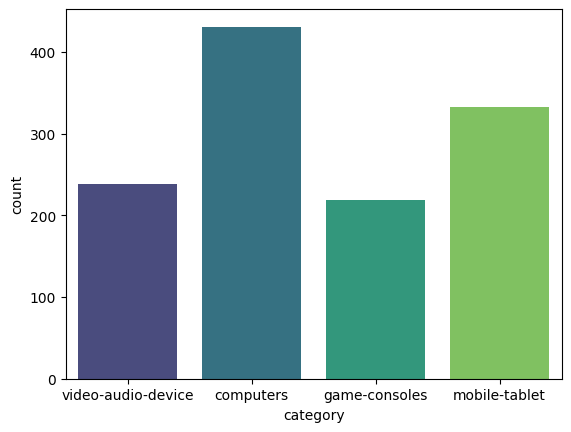

In [112]:
sns.countplot(x='category', data=df, palette='viridis')

<Axes: xlabel='city', ylabel='count'>

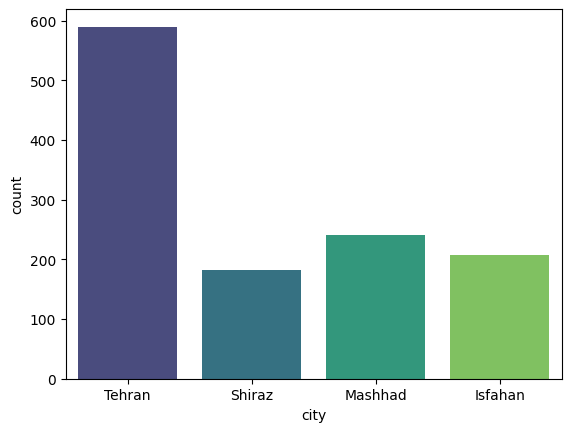

In [113]:
sns.countplot(x='city', data=df, palette='viridis')

In [114]:
df.isnull().sum()

title            55
desc             55
brand          1022
image-count       0
price            57
category          0
city              0
dtype: int64

<div dir="rtl">
    <h3 style="padding-bottom: 20px;">پاک‌سازی داده</h3>
    <h4>حذف سطر های با عنوان و قیمت null</h4>
</div>

In [115]:
df = df.dropna(subset=['title', 'price'])
df.isnull().sum()

title            0
desc             0
brand          965
image-count      0
price            0
category         0
city             0
dtype: int64

<div dir="rtl">
    <h4 style="padding-bottom: 20px;">حذف unicode ها</h4>
    <div style="font-size: 16px;line-height: 1.6;">
        در متن عناوین و توضیحات 
        تعدادی
        unicode  وجود دارد.
        به عنوان اولین مرحله این
        unicode ها حذف می‌شود.
   </div> 
</div>


In [116]:
def remove_unicode(text):
    # regular expression pattern to match Unicode characters
    pattern = r'[^\u0600-\u06FF\u0660-\u0669\u06F0-\u06F9\u0020\u002E\u002C\u061B\u003A\u002D\u002F\u0028\u0029\u005B\u005D\u007B\u007D\u00AB\u00BB\u2018\u2019\u201C\u201D\u00A0\u200C\u200F]+'
    
    text = text.replace("\n", " ")
    
    # remove Unicode characters using re.sub()
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

# remove unicodes 
df['title'] = df['title'].apply(lambda x: remove_unicode(x))
df['desc'] = df['desc'].apply(lambda x: remove_unicode(x))


<ipython-input-116-e13b319793e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].apply(lambda x: remove_unicode(x))
<ipython-input-116-e13b319793e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['desc'] = df['desc'].apply(lambda x: remove_unicode(x))


<div dir="rtl">
    <h4 style="padding-bottom: 20px;">تبدیل قیمت به مقدار عددی</h4>
</div>


In [117]:
def get_numeric_price(text):
    number_str = ''.join(filter(str.isdigit, text))
    return int(number_str)

df['price'] = df['price'].apply(lambda x: get_numeric_price(x))

<div dir="rtl">
    <h3 style="padding-bottom: 20px;">کدگذاری داده</h3>
    <div style="font-size: 16px;line-height: 1.6;">
       در این بخش داده‌های غیر‌عددی به داده‌های عددی تبدیل می‌گردند.
   </div> 
</div>

In [118]:
le = preprocessing.LabelEncoder()
df['brand'] = le.fit_transform(df['brand'].values)
df['category'] = le.fit_transform(df['category'].values)
df['city'] = le.fit_transform(df['city'].values)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164 entries, 0 to 1220
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1164 non-null   object
 1   desc         1164 non-null   object
 2   brand        1164 non-null   int64 
 3   image-count  1164 non-null   int64 
 4   price        1164 non-null   int64 
 5   category     1164 non-null   int64 
 6   city         1164 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 72.8+ KB


<div dir="rtl">
    <h3 style="padding-bottom: 20px;">تولید بازنمایی متنی</h3>
    <h3 style="padding-bottom: 20px;">TF-IDF</h3>
    <div style="font-size: 16px;line-height: 1.6;">
    در این بخش بازنمایی مناسب برای ستون‌های title و desc به سه روش تولید می‌شود.
    </div>
</div>

In [120]:
df['text'] = df['title'] + ' ' + df['desc']
df.drop(['title', 'desc'], axis=1, inplace=True)

In [121]:
# Preprocess the title column using Hazm
stemmer = Stemmer()
normalizer = Normalizer()
df['preprocessed'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in word_tokenize(normalizer.normalize(x))]))

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list(), ngram_range=(1, 2))

tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed'])

feature_names = column_names = [f"text_vector_{i}" for i in range(len(tfidf_matrix.toarray()[0]))]

temp_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df.reset_index(drop=True, inplace=True)
temp_df.reset_index(drop=True, inplace=True)

df.drop('preprocessed', axis=1, inplace=True)
tfidf_df = pd.concat([df, temp_df], axis=1)
tfidf_df.drop('text', axis=1, inplace=True)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  warnings.warn(


In [122]:
tfidf_df

,brand,image-count,price,category,city,text_vector_0,text_vector_1,text_vector_2,text_vector_3,text_vector_4,...,text_vector_23539,text_vector_23540,text_vector_23541,text_vector_23542,text_vector_23543,text_vector_23544,text_vector_23545,text_vector_23546,text_vector_23547,text_vector_23548
0,12,4,3700000,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,1,1400000,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12,1,9000000,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,2,650000,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,2,4200000,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,12,3,45000,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1160,12,2,550000,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161,12,1,55000,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1162,12,1,10000,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0





<div dir="rtl">
    <h3 dir="rtl" style="padding-bottom: 20px">Pre-trained BERT</h3>
    <div style="font-size: 16px;line-height: 1.6;">
    در این بخش به دلیل محدود بودن RAM در دسترس در colab پردازش تنها بر روی ۱۰ نمونه از داده‌های کل صورت می‌گیرد.
 </div>
</div>

In [123]:
# Load the pre-trained BERT model and tokenizer for Persian text
model_name = 'HooshvareLab/bert-fa-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [124]:
Y = df.iloc[0:10,:]['category']
X = df.loc[:, df.columns != 'category'].iloc[0:10,:]

# Split the dataset into training and validation sets
bert_train_data, bert_val_data, bert_train_labels, bert_val_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Tokenize the input sequences and get the BERT embeddings
bert_train_encodings = tokenizer(list(bert_train_data['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')
bert_val_encodings = tokenizer(list(bert_val_data['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')

bert_train_embeddings = bert_model(**bert_train_encodings)[0][:, 0, :]
bert_val_embeddings = bert_model(**bert_val_encodings)[0][:, 0, :]


In [125]:
feature_names = column_names = [f"text_vector_{i}" for i in range(len(bert_train_embeddings[0]))]
temp_df = pd.DataFrame(bert_train_embeddings.detach().numpy(), columns=feature_names)

bert_train_data.reset_index(drop=True, inplace=True)
temp_df.reset_index(drop=True, inplace=True)

bert_df = pd.concat([bert_train_data, temp_df], axis=1)
bert_df.drop('text', axis=1, inplace=True)

temp_df = pd.DataFrame(bert_val_embeddings.detach().numpy(), columns=feature_names)

bert_val_data.reset_index(drop=True, inplace=True)
temp_df.reset_index(drop=True, inplace=True)

bert_df_test = pd.concat([bert_val_data, temp_df], axis=1)
bert_df_test.drop('text', axis=1, inplace=True)

bert_df

,brand,image-count,price,city,text_vector_0,text_vector_1,text_vector_2,text_vector_3,text_vector_4,text_vector_5,...,text_vector_758,text_vector_759,text_vector_760,text_vector_761,text_vector_762,text_vector_763,text_vector_764,text_vector_765,text_vector_766,text_vector_767
0,12,2,3000000,3,-0.336082,0.200147,1.053138,-0.043427,0.338867,1.351218,...,1.343394,-0.853243,0.272209,0.463359,-0.664118,0.041435,0.168871,0.732924,0.397439,-0.420487
1,12,4,3700000,3,0.229775,0.577012,-0.005407,0.169216,-0.142544,0.834574,...,1.144959,-0.212640,-0.074677,0.404581,0.746716,0.606350,1.103523,0.515309,-0.158027,-0.742577
2,12,6,6350000,3,-0.214394,-0.351248,1.478818,0.772265,0.022562,-0.069026,...,0.554462,-0.405687,-0.059943,0.441306,-1.221554,0.326375,-0.218121,1.210317,0.062439,-0.641854
3,12,1,9000000,3,1.051590,0.352655,1.603401,0.132107,-0.118267,0.703873,...,1.253296,0.444773,0.412712,-0.633503,-0.113932,0.076875,-0.161759,-0.152605,0.576430,-1.354515
4,12,1,16300000,3,0.820665,1.264083,1.489563,0.645373,0.102532,0.604402,...,0.991750,-0.178065,0.580687,0.125826,-0.234057,1.184576,-0.135967,0.457605,-0.568547,-0.435075
5,12,2,4200000,3,0.325233,0.018698,1.624685,0.372218,-0.308477,0.126869,...,0.739976,0.790584,0.737448,-0.473248,0.242386,1.206023,0.709999,1.061233,-0.603628,-0.952310
6,12,2,650000,3,1.345464,-0.691870,1.606326,0.029029,-1.145691,0.064277,...,-0.168275,1.874840,0.202324,0.346616,0.799792,0.341189,0.648042,-0.678840,0.260010,-1.400522
7,12,2,500000,3,0.319775,0.484986,0.849790,-0.224354,0.304685,0.805175,...,0.734505,0.947874,0.222957,-0.547453,-1.064314,1.185591,-1.146926,-0.686741,0.085195,-1.166368


<div dir="rtl">
    <h3 dir="rtl" style="padding-bottom: 20px">Bag of words</h3>
</div>

In [126]:
# Preprocess the text
lemmatizer = Lemmatizer()
stopwords = stopwords_list()
df['text'] = df['text'].apply(normalizer.normalize)
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords])
df['text'] = df['text'].apply(' '.join)

# Split the dataset into training and testing sets
bow_train_df = df.sample(frac=0.8, random_state=42)
bow_test_df = df.drop(bow_train_df.index)

# Create the bag-of-words representation
vectorizer = CountVectorizer()
bow_train_features = vectorizer.fit_transform(bow_train_df['text'])
bow_test_features = vectorizer.transform(bow_test_df['text'])

feature_names = column_names = [f"text_vector_{i}" for i in range(bow_train_features[0].shape[1])]

temp_df = pd.DataFrame(bow_train_features.toarray(), columns=feature_names)

bow_train_df.reset_index(drop=True, inplace=True)
temp_df.reset_index(drop=True, inplace=True)

bow_df = pd.concat([bow_train_df, temp_df], axis=1)
bow_df.drop('text', axis=1, inplace=True)

temp_df = pd.DataFrame(bow_test_features.toarray(), columns=feature_names)

bow_test_df.reset_index(drop=True, inplace=True)
temp_df.reset_index(drop=True, inplace=True)

bow_df_test = pd.concat([bow_test_df, temp_df], axis=1)
bow_df_test.drop('text', axis=1, inplace=True)

bow_df

,brand,image-count,price,category,city,text_vector_0,text_vector_1,text_vector_2,text_vector_3,text_vector_4,...,text_vector_3733,text_vector_3734,text_vector_3735,text_vector_3736,text_vector_3737,text_vector_3738,text_vector_3739,text_vector_3740,text_vector_3741,text_vector_3742
0,12,4,400000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,3,45000000,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,5,13500000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12,2,700000,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1,15950000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,12,5,1350000,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927,12,1,850000,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
928,12,1,9500000,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
929,12,3,90000,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div dir="rtl">
    <h3 style="padding-bottom: 20px;">مهندسی ویژگی</h3>
    <div style="font-size: 16px;line-height: 1.6;">
    در این بخش PCA بر روی bert_df و انتخاب ویژگی به صورت انسانی بر روی tfidf_df اعمال می‌شود.
    </div>
</div>

<h3 style="padding-bottom: 20px;" dir="rtl">PCA</h3>


In [127]:
pca = PCA(n_components=2)

X_train_bert = bert_df.loc[:, bert_df.columns != 'category']
X_test_bert = bert_df_test.loc[:, bert_df_test.columns != 'category']
# bert_train_labels, bert_val_labels

X_train_bert_pca = pca.fit_transform(X_train_bert)
X_test_bert_pca = pca.fit_transform(X_test_bert)

<h3 style="padding-bottom: 20px;" dir="rtl">انتخاب انسانی بازنمایی عنوان و توضیحات به عنوان تک ویژگی</h3>


In [128]:
y = tfidf_df.loc[:, ['category']]
X = tfidf_df.drop(['brand', 'image-count', 'price', 'city', 'category'], axis=1)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tfidf

,text_vector_0,text_vector_1,text_vector_2,text_vector_3,text_vector_4,text_vector_5,text_vector_6,text_vector_7,text_vector_8,text_vector_9,...,text_vector_23539,text_vector_23540,text_vector_23541,text_vector_23542,text_vector_23543,text_vector_23544,text_vector_23545,text_vector_23546,text_vector_23547,text_vector_23548
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div dir="rtl">
    <h3 style="padding-bottom: 20px;">ناهمگنی توزیع داده</h3>
    <div style="font-size: 16px;line-height: 1.6;">
در این بخش بر روی داد‌ها با ترکیب زیر مدل آموزش داده می‌شود:

 * bert + pca 
 * tf-idf + undersampling
 * bow + weighted loss 
    </div>
</div>

<h3 style="padding-bottom: 20px;" dir="rtl">Bert + PCA</h3>


In [201]:
from torch.utils.data import DataLoader, TensorDataset

# Define the network architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, optimizer, criterion, train_loader, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2 == 1:  # Print every 100 mini-batches
                print('[epoch : %d, i : %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')


# Convert the data to PyTorch tensors
X = torch.tensor(X_train_bert.values, dtype=torch.float32)
y = torch.tensor(bert_train_labels.values, dtype=torch.long)
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Initialize the network and optimizer
model = MLP(X_train_bert.shape[1], 20, 4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the network
train(model, optimizer, criterion, train_loader, 10)


[epoch : 1, i :     2] loss: 88.117
[epoch : 1, i :     4] loss: 0.000
[epoch : 2, i :     2] loss: 0.000
[epoch : 2, i :     4] loss: 0.000
[epoch : 3, i :     2] loss: 0.000
[epoch : 3, i :     4] loss: 0.000
[epoch : 4, i :     2] loss: 0.000
[epoch : 4, i :     4] loss: 0.000
[epoch : 5, i :     2] loss: 0.000
[epoch : 5, i :     4] loss: 0.000
[epoch : 6, i :     2] loss: 0.000
[epoch : 6, i :     4] loss: 0.000
[epoch : 7, i :     2] loss: 0.000
[epoch : 7, i :     4] loss: 0.000
[epoch : 8, i :     2] loss: 0.000
[epoch : 8, i :     4] loss: 0.000
[epoch : 9, i :     2] loss: 0.000
[epoch : 9, i :     4] loss: 0.000
[epoch : 10, i :     2] loss: 0.000
[epoch : 10, i :     4] loss: 0.000
Finished Training


<h3 style="padding-bottom: 20px;" dir="rtl">tf-idf + randodm undersampling</h3>


In [202]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train_tfidf)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# shuffle the rows of the new dataset
df_balanced = df_balanced.sample(frac=1, random_state=42)

df_balanced

,text_vector_0,text_vector_1,text_vector_2,text_vector_3,text_vector_4,text_vector_5,text_vector_6,text_vector_7,text_vector_8,text_vector_9,...,text_vector_23540,text_vector_23541,text_vector_23542,text_vector_23543,text_vector_23544,text_vector_23545,text_vector_23546,text_vector_23547,text_vector_23548,category
674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [203]:
# Convert the data to PyTorch tensors
X = torch.tensor(X_train_tfidf.values, dtype=torch.float32)
y = torch.tensor([y[0] for y in y_train_tfidf.values], dtype=torch.long)
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Initialize the network and optimizer
model = MLP(X_train_tfidf.shape[1], 20, 4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the network
train(model, optimizer, criterion, train_loader, 5)


[epoch : 1, i :     2] loss: 0.031
[epoch : 1, i :     4] loss: 0.028
[epoch : 1, i :     6] loss: 0.030
[epoch : 1, i :     8] loss: 0.027
[epoch : 1, i :    10] loss: 0.027
[epoch : 1, i :    12] loss: 0.028
[epoch : 1, i :    14] loss: 0.027
[epoch : 1, i :    16] loss: 0.028
[epoch : 1, i :    18] loss: 0.028
[epoch : 1, i :    20] loss: 0.026
[epoch : 1, i :    22] loss: 0.028
[epoch : 1, i :    24] loss: 0.028
[epoch : 1, i :    26] loss: 0.028
[epoch : 1, i :    28] loss: 0.028
[epoch : 1, i :    30] loss: 0.028
[epoch : 1, i :    32] loss: 0.026
[epoch : 1, i :    34] loss: 0.027
[epoch : 1, i :    36] loss: 0.028
[epoch : 1, i :    38] loss: 0.026
[epoch : 1, i :    40] loss: 0.028
[epoch : 1, i :    42] loss: 0.024
[epoch : 1, i :    44] loss: 0.026
[epoch : 1, i :    46] loss: 0.025
[epoch : 1, i :    48] loss: 0.028
[epoch : 1, i :    50] loss: 0.027
[epoch : 1, i :    52] loss: 0.025
[epoch : 1, i :    54] loss: 0.025
[epoch : 1, i :    56] loss: 0.032
[epoch : 1, i :    5

<h3 style="padding-bottom: 20px;" dir="rtl">BOW + weighted loss</h3>


In [204]:
y = bow_df.loc[:, ['category']]
X = bow_df.drop(['brand', 'image-count', 'price', 'city', 'category'], axis=1)

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.2, random_state=42)


# Load the dataset
train_data = torch.tensor(X_train_bow.values, dtype=torch.float32)
train_labels = torch.tensor([y[0] for y in y_train_bow.values], dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

# Calculate class weights based on frequency
class_freq = torch.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (len(class_freq) * class_freq.float())

# Initialize the network and optimizer
model = MLP(train_data.shape[1], 20, 4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the loss function with class weights
def weighted_cross_entropy_loss(outputs, labels):
    return F.cross_entropy(outputs, labels, weight=class_weights)

# Train the network using the weighted loss
train(model, optimizer, weighted_cross_entropy_loss, train_loader, 10)


[epoch : 1, i :     2] loss: 0.027
[epoch : 1, i :     4] loss: 0.026
[epoch : 1, i :     6] loss: 0.026
[epoch : 1, i :     8] loss: 0.027
[epoch : 1, i :    10] loss: 0.022
[epoch : 1, i :    12] loss: 0.031
[epoch : 1, i :    14] loss: 0.031
[epoch : 1, i :    16] loss: 0.025
[epoch : 1, i :    18] loss: 0.020
[epoch : 1, i :    20] loss: 0.026
[epoch : 1, i :    22] loss: 0.025
[epoch : 1, i :    24] loss: 0.022
[epoch : 1, i :    26] loss: 0.022
[epoch : 1, i :    28] loss: 0.027
[epoch : 1, i :    30] loss: 0.031
[epoch : 1, i :    32] loss: 0.026
[epoch : 1, i :    34] loss: 0.014
[epoch : 1, i :    36] loss: 0.021
[epoch : 1, i :    38] loss: 0.019
[epoch : 1, i :    40] loss: 0.028
[epoch : 1, i :    42] loss: 0.022
[epoch : 1, i :    44] loss: 0.026
[epoch : 1, i :    46] loss: 0.026
[epoch : 1, i :    48] loss: 0.027
[epoch : 1, i :    50] loss: 0.007
[epoch : 1, i :    52] loss: 0.021
[epoch : 1, i :    54] loss: 0.024
[epoch : 1, i :    56] loss: 0.023
[epoch : 1, i :    5